<a href="https://colab.research.google.com/github/ele9996/Temperature-and-Humidity-forecasting/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Temperature and humidity forecasting

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os
from zipfile import ZipFile

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
#parser = argparse.ArgumentParser()
#parser.add_argument('--model', type=str, required=True, help='model name')
#parser.add_argument('--labels', type=int, required=True, help='model output')
#args = parser.parse_args()

#per prova
label_to_predict= 2
model_name= "my_model"

##Import Dataset

In [5]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
df

13574144/13568290 [==============================] - 1s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [6]:
selected_feat=['T (degC)','rh (%)']
selected_df=df[selected_feat]    #df.loc[:,selected_feat].values

selected_df

,T (degC),rh (%)
0,-8.02,93.30
1,-8.41,93.40
2,-8.51,93.90
3,-8.31,94.20
4,-8.27,94.10
...,...,...
420546,-4.05,73.10
420547,-3.35,69.71
420548,-3.16,67.91
420549,-4.23,71.80


In [7]:
#Data conversion to a 32-bit float numpy array

selected_array=selected_df.to_numpy(dtype=np.float32)   #.astype(np.float32)
selected_array

array([[-8.02, 93.3 ],
       [-8.41, 93.4 ],
       [-8.51, 93.9 ],
       ...,
       [-3.16, 67.91],
       [-4.23, 71.8 ],
       [-4.82, 75.7 ]], dtype=float32)

In [8]:
#I define training (70%),validation (10%) and test data set (20%)

n=len(selected_array)
train_data=selected_array[0:int(n*0.7)]
val_data=selected_array[int(n*0.7):int(n*0.8)]
test_data = selected_array[int(n*0.8):]


In [9]:
#I define mean and standard deviation (for normalization)
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

#I define the size of the window and Label Options (which is a number)
#LABEL_OPTIONS= is a number used to make my model understand if I'm predicting only temperature, only humidity or humidity and temperature together.
#              is 0 for temperature, 1 for humidity, 2 for both

input_width = 6
LABEL_OPTIONS =label_to_predict
#LABEL_OPTIONS = args.labels


##Window Generation


In [10]:
#features: temperature, humidity (x6 values)
#one temperature value (the one corresponding to the next time interval)


class WindowGenerator:
    def __init__(self, input_width, label_options, mean, std):
        self.input_width = input_width
        self.label_options = label_options
        self.mean = tf.reshape(tf.convert_to_tensor(mean), [1, 1, 2])
        self.std = tf.reshape(tf.convert_to_tensor(std), [1, 1, 2])

    def split_window(self, features):
        input_indeces = np.arange(self.input_width)
        inputs = features[:, :-1, :]

        if self.label_options < 2:
            labels = features[:, -1, self.label_options]
            labels = tf.expand_dims(labels, -1)
            num_labels = 1
        else:
            labels = features[:, -1, :]
            num_labels = 2

        inputs.set_shape([None, self.input_width, 2])
        labels.set_shape([None, num_labels])

        return inputs, labels

    def normalize(self, features):
        features = (features - self.mean) / (self.std + 1.e-6)

        return features

    def preprocess(self, features):
        inputs, labels = self.split_window(features)
        inputs = self.normalize(inputs)

        return inputs, labels

    def make_dataset(self, data, train):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=input_width+1,
                sequence_stride=1,
                batch_size=32)
        ds = ds.map(self.preprocess)
        ds = ds.cache()
        if train is True:
            ds = ds.shuffle(100, reshuffle_each_iteration=True)

        return ds

In [11]:
generator = WindowGenerator(input_width, LABEL_OPTIONS, mean, std)
train_ds = generator.make_dataset(train_data, True)
val_ds = generator.make_dataset(val_data, False)
test_ds = generator.make_dataset(test_data, False)




##Dataset check

In [12]:
# split datasets into input (X) and output (y) variables

#train
for x_train,y_train in train_ds.take(1):
  print(x_train.shape)
  print(y_train.shape)


#validation
for x_val,y_val in val_ds.take(1):
  print(x_val.shape)
  print(y_val.shape)


#test
for x_test,y_test in test_ds.take(1):
  print(x_test.shape)
  print(y_test.shape)


(32, 6, 2)
(32, 2)
(32, 6, 2)
(32, 2)
(32, 6, 2)
(32, 2)


##Class to measure the MAE separately on the two outputs

In [13]:
class MultiOutputMAE(tf.keras.metrics.Metric):
    
    def __init__(self, name= 'mean_absolute_error', **kwargs):
      super().__init__(name=name, **kwargs)
      self.total= self.add_weight('total', initializer='zeros', shape=(2,))
      self.count = self.add_weight('count', initializer= 'zeros')
    
    def update_state(self, y_true, y_pred, sample_weight= None):
      error= tf.abs(y_pred - y_true)
      error= tf.reduce_mean(error, axis=0)
      self.total.assign_add(error)
      self.count.assign_add(1.)
      return
    
    def reset_states (self):
      self.count.assign(tf.zeros_like(self.count))
      self.total.assign(tf.zeros_like(self.total))
      return

    def result(self):
      result = tf.math.divide_no_nan(self.total, self.count)
      return result


##MPL Model

In [14]:
#MLP Model definition
mlp_model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=2) #metti 2 se vuoi fare doppia predizione 1 se ne vuoi fare solo una 
])

In [15]:
#Training, evaluation and testing with mlp model


mlp_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
mlp_model.fit(train_ds, epochs=20)


Epoch 1/20
9200/9200 [==============================] - 30s 3ms/step - loss: 43.2861 - mse: 43.2861
Epoch 2/20
9200/9200 [==============================] - 10s 1ms/step - loss: 1.2340 - mse: 1.2340
Epoch 3/20
9200/9200 [==============================] - 10s 1ms/step - loss: 0.9593 - mse: 0.9593
Epoch 4/20
9200/9200 [==============================] - 10s 1ms/step - loss: 0.9055 - mse: 0.9055
Epoch 5/20
9200/9200 [==============================] - 10s 1ms/step - loss: 0.8847 - mse: 0.8847
Epoch 6/20
9200/9200 [==============================] - 10s 1ms/step - loss: 0.8390 - mse: 0.8390
Epoch 7/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.9498 - mse: 0.9498
Epoch 8/20
9200/9200 [==============================] - 10s 1ms/step - loss: 0.7886 - mse: 0.7886
Epoch 9/20
9200/9200 [==============================] - 10s 1ms/step - loss: 0.7668 - mse: 0.7668
Epoch 10/20
9200/9200 [==============================] - 10s 1ms/step - loss: 0.8006 - mse: 0.8006
Epoch 11/20
9200/

In [16]:
#model evaluation on validation set

mlp_model.compile(loss='mae', optimizer='adam')
val_loss= mlp_model.evaluate(val_ds) 

1315/1315 [==============================] - 4s 3ms/step - loss: 0.9785


In [17]:
#test the model

mlp_model.compile(loss='mse', optimizer='adam', metrics=[MultiOutputMAE()])
#mlp_model.compile(loss='mae', optimizer='adam')
test_loss= mlp_model.evaluate(test_ds) 



2629/2629 [==============================] - 8s 3ms/step - loss: 1.7281 - mean_absolute_error: 0.9371


In [18]:
#check 
predictions = mlp_model.predict(x_test)
# summarize the first 5 cases
for i in range(5):
	print('%s => %s (expected %s)' % (x_test[i].numpy().tolist(), predictions[i], y_test[i]))

[[0.9651238322257996, -0.9859264492988586], [0.9535689353942871, -0.9665994048118591], [0.9293032288551331, -0.9146581292152405], [0.9027267098426819, -0.8609045147895813], [0.8761501312255859, -0.7860122323036194], [0.8553510308265686, -0.7286349534988403]] => [16.889565 63.959797] (expected tf.Tensor([16.27 65.14], shape=(2,), dtype=float32))
[[0.9535689353942871, -0.9665994048118591], [0.9293032288551331, -0.9146581292152405], [0.9027267098426819, -0.8609045147895813], [0.8761501312255859, -0.7860122323036194], [0.8553510308265686, -0.7286349534988403], [0.8276189565658569, -0.6501188278198242]] => [16.57534 65.48229] (expected tf.Tensor([16.09 66.12], shape=(2,), dtype=float32))
[[0.9293032288551331, -0.9146581292152405], [0.9027267098426819, -0.8609045147895813], [0.8761501312255859, -0.7860122323036194], [0.8553510308265686, -0.7286349534988403], [0.8276189565658569, -0.6501188278198242], [0.8068197965621948, -0.5909294486045837]] => [16.395395 66.25237 ] (expected tf.Tensor([15.

In [19]:
#number of parameters VS mae

mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 18,434
Trainable params: 18,434
Non-trainable params: 0
_________________________________________________________________


#CNN 1D

In [20]:
#CNN_1D Model definition

cnn_1d_model = keras.Sequential([
    keras.layers.Conv1D(filters=64,kernel_size=3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=2)
])

In [21]:
#Training, evaluation and testing with mlp model

cnn_1d_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
cnn_1d_model.fit(train_ds, epochs=20)

Epoch 1/20
9200/9200 [==============================] - 11s 1ms/step - loss: 40.6813 - mse: 40.6813
Epoch 2/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.9913 - mse: 0.9913
Epoch 3/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.8268 - mse: 0.8268
Epoch 4/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.8122 - mse: 0.8122
Epoch 5/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.7239 - mse: 0.7239
Epoch 6/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.7454 - mse: 0.7454
Epoch 7/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.7177 - mse: 0.7177
Epoch 8/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.7279 - mse: 0.7279
Epoch 9/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.6984 - mse: 0.6984
Epoch 10/20
9200/9200 [==============================] - 11s 1ms/step - loss: 0.6615 - mse: 0.6615
Epoch 11/20
9200/

In [22]:
#model evaluation on validation set

cnn_1d_model.compile(loss='mae', optimizer='adam')
val_loss= cnn_1d_model.evaluate(val_ds) 

1315/1315 [==============================] - 1s 1ms/step - loss: 0.9324


In [23]:
#test the model
#model evaluation on validation set

cnn_1d_model.compile(loss='mse', optimizer='adam', metrics=[MultiOutputMAE()])
#cnn_1d_model.compile(loss='mae', optimizer='adam')
test_loss= cnn_1d_model.evaluate(test_ds) 

2629/2629 [==============================] - 3s 1ms/step - loss: 2.4455 - mean_absolute_error: 1.0920


In [24]:
#check 
predictions = cnn_1d_model.predict(x_test)
# summarize the first 5 cases
for i in range(5):
	print('%s => %s (expected %s)' % (x_test[i].numpy().tolist(), predictions[i], y_test[i]))

[[0.9651238322257996, -0.9859264492988586], [0.9535689353942871, -0.9665994048118591], [0.9293032288551331, -0.9146581292152405], [0.9027267098426819, -0.8609045147895813], [0.8761501312255859, -0.7860122323036194], [0.8553510308265686, -0.7286349534988403]] => [15.3723135 62.327816 ] (expected tf.Tensor([16.27 65.14], shape=(2,), dtype=float32))
[[0.9535689353942871, -0.9665994048118591], [0.9293032288551331, -0.9146581292152405], [0.9027267098426819, -0.8609045147895813], [0.8761501312255859, -0.7860122323036194], [0.8553510308265686, -0.7286349534988403], [0.8276189565658569, -0.6501188278198242]] => [15.104699 63.98885 ] (expected tf.Tensor([16.09 66.12], shape=(2,), dtype=float32))
[[0.9293032288551331, -0.9146581292152405], [0.9027267098426819, -0.8609045147895813], [0.8761501312255859, -0.7860122323036194], [0.8553510308265686, -0.7286349534988403], [0.8276189565658569, -0.6501188278198242], [0.8068197965621948, -0.5909294486045837]] => [14.999152 64.81309 ] (expected tf.Tensor(

In [26]:
cnn_1d_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             448       
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


#LSTM

In [28]:
#LSTM Model definition

lstm_model = keras.Sequential([
    keras.layers.LSTM(units=64),
    keras.layers.Flatten(),
    keras.layers.Dense(units=2)
])

In [29]:
#Training, evaluation and testing with mlp model

lstm_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm_model.fit(train_ds, epochs=20)

Epoch 1/20
9200/9200 [==============================] - 35s 4ms/step - loss: 154.0661 - mse: 154.0661
Epoch 2/20
9200/9200 [==============================] - 34s 4ms/step - loss: 1.2588 - mse: 1.2588
Epoch 3/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.7200 - mse: 0.7200
Epoch 4/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.6459 - mse: 0.6459
Epoch 5/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.6033 - mse: 0.6033
Epoch 6/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.5814 - mse: 0.5814
Epoch 7/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.5699 - mse: 0.5699
Epoch 8/20
9200/9200 [==============================] - 36s 4ms/step - loss: 0.5649 - mse: 0.5649
Epoch 9/20
9200/9200 [==============================] - 35s 4ms/step - loss: 0.5566 - mse: 0.5566
Epoch 10/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.5524 - mse: 0.5524
Epoch 11/20
920

In [30]:
#model evaluation on validation set

lstm_model.compile(loss='mae', optimizer='adam')
val_loss= lstm_model.evaluate(val_ds) 

1315/1315 [==============================] - 2s 1ms/step - loss: 0.3694


In [31]:
#test the model

lstm_model.compile(loss='mse', optimizer='adam', metrics=[MultiOutputMAE()])
#lstm_model.compile(loss='mae', optimizer='adam')
test_loss= lstm_model.evaluate(test_ds) 

2629/2629 [==============================] - 4s 1ms/step - loss: 0.5470 - mean_absolute_error: 0.3967


In [32]:
#check 
predictions = lstm_model.predict(x_test)
# summarize the first 5 cases
for i in range(5):
	print('%s => %s (expected %s)' % (x_test[i].numpy().tolist(), predictions[i], y_test[i]))

[[0.9651238322257996, -0.9859264492988586], [0.9535689353942871, -0.9665994048118591], [0.9293032288551331, -0.9146581292152405], [0.9027267098426819, -0.8609045147895813], [0.8761501312255859, -0.7860122323036194], [0.8553510308265686, -0.7286349534988403]] => [16.363033 64.574776] (expected tf.Tensor([16.27 65.14], shape=(2,), dtype=float32))
[[0.9535689353942871, -0.9665994048118591], [0.9293032288551331, -0.9146581292152405], [0.9027267098426819, -0.8609045147895813], [0.8761501312255859, -0.7860122323036194], [0.8553510308265686, -0.7286349534988403], [0.8276189565658569, -0.6501188278198242]] => [16.052969 66.157135] (expected tf.Tensor([16.09 66.12], shape=(2,), dtype=float32))
[[0.9293032288551331, -0.9146581292152405], [0.9027267098426819, -0.8609045147895813], [0.8761501312255859, -0.7860122323036194], [0.8553510308265686, -0.7286349534988403], [0.8276189565658569, -0.6501188278198242], [0.8068197965621948, -0.5909294486045837]] => [15.944467 66.85835 ] (expected tf.Tensor([1

In [33]:
cnn_1d_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             448       
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


#Save models

In [34]:
mlp_model.save('mpl_model.h5')
cnn_1d_model.save('cnn_1d_model.h5')
lstm_model.save('lstm_model.h5') 

##Plot #Params vs MAE

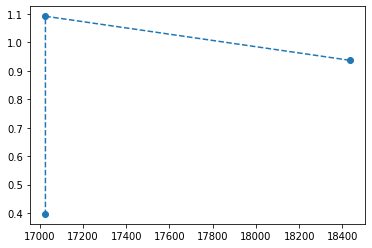

In [37]:
x=[18434, 17026, 17026]
y=[0.9371, 1.0920 , 0.3967]

plt.plot(x,y,'o--')